In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.risk.final_model_loss_train_risk import *
from model.final_model.risk.final_model_risk import PatientOutcomeModel
from model.lstm.autoencoder_v3_lstm import  TSAutoencoder
from model.final_model.risk.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)


train_loader = DataLoader( dataset_train,batch_size=128,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=128,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=128,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=128, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [3]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/baseline/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_lstm/risk/resampled_30"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=50, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  theta=1, 
            patience = 20 )

In [ ]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_lstm/risk/resampled_30/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [ ]:
plot_training_history(history)

In [11]:
output= test_patient_outcome_model(model, test_loader, device)

Test Risk    → RMSE: 0.1103


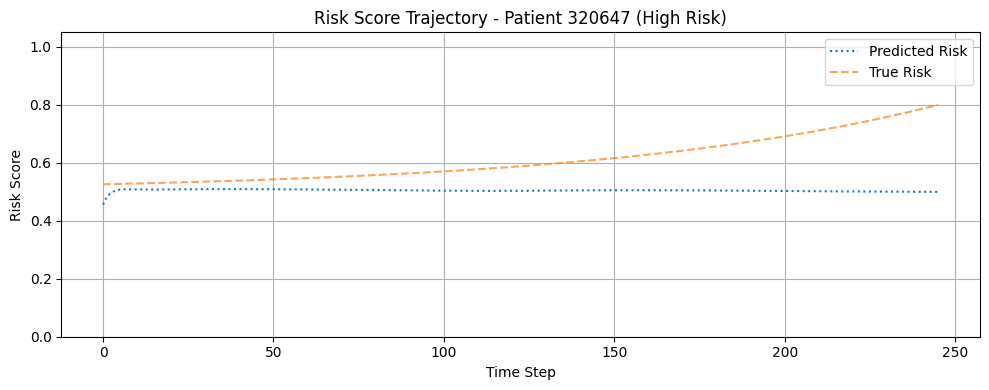

In [12]:
plot_patient_risk_score(model, test_loader, patient_index=398, device=device)

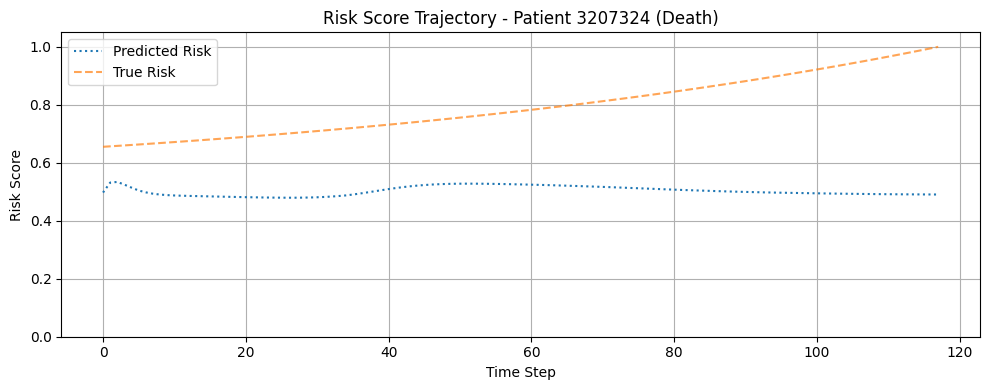

In [13]:
plot_patient_risk_score(model, test_loader, patient_index=400, device=device)

In [23]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


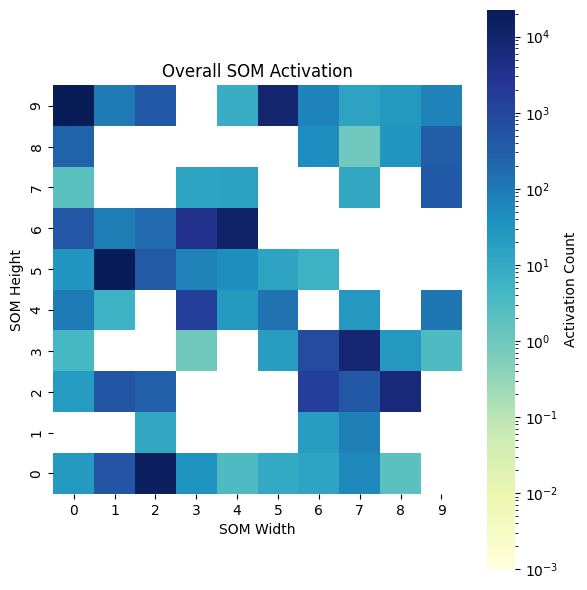

In [24]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

In [27]:
def plot_som_avg_risk(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        vmin=0.0, vmax=1.0,
        cmap=cmap,
        annot=True, fmt=".2f",
        # linewidths=.5, linecolor="gray"
    )
    plt.title("SOM Node Avg Risk")
    plt.xlabel("SOM Width"); plt.ylabel("SOM Height")
    plt.gca().invert_yaxis() #
    plt.tight_layout()
    plt.show()


--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


--> Heatmap computation complete.


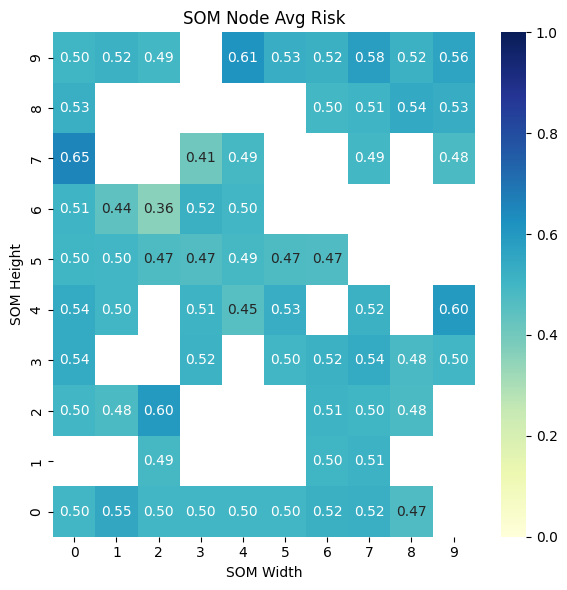

In [28]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

In [16]:
# --- 1. 计算热力图 ---
risk_heatmap = compute_som_avg_risk(model, test_loader, device, som_dim=(10, 10))

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 4/4 [00:16<00:00,  4.24s/it]

--> Heatmap computation complete.


--- Searching for specified patient IDs: ['1327763'] ---


Searching for patients:   0%|          | 0/4 [00:05<?, ?it/s]

  -> Found 1 target(s) in current batch. Running forward pass...
    -> Computed trajectory for Patient ID: 1327763 (Category: 1)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [529]


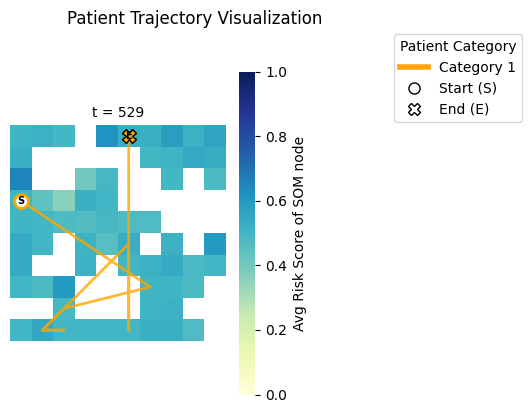

In [21]:
#cat=1
# --- 2. 计算目标病人的轨迹 ---
patient_ids =  ['1327763'] 

targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

#开始，1/4处，1/2处，3/4处，和结束前一个点
# max_len // 2,  
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2452034'] ---


Searching for patients:  25%|██▌       | 1/4 [00:09<00:27,  9.17s/it]

  -> Found 1 target(s) in current batch. Running forward pass...
    -> Computed trajectory for Patient ID: 2452034 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [356]


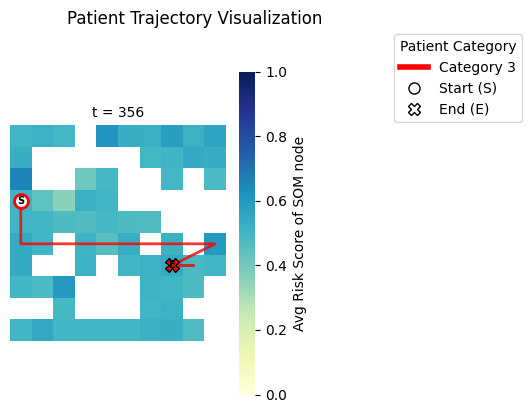

In [22]:
#cat=3
patient_ids = ['2452034'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)